In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
import os
import time
from datetime import datetime
import ctypes
import winsound
import win32com.client as win
#from scipy.spatial import disctance as dist

In [2]:
#face_classifier = cv2.CascadeClassifier('./data/haarcascade_frontalface_default.xml')
#eye_classifier = cv2.CascadeClassifier('./data/haarcascade_eye.xml')

# Initializing the face detector and facial landmark predictor 
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("data/shape_predictor_68_face_landmarks.dat")

In [3]:
# Defining the mid-point
def midpoint(p1 ,p2):
    return int((p1.x + p2.x)/2), int((p1.y + p2.y)/2)

# Defining the Euclidean distance
def euclidean_distance(leftx,lefty, rightx, righty):
    return np.sqrt((leftx-rightx)**2 +(lefty-righty)**2)

# Defining the eye aspect ratio
def get_EAR(eye_points, facial_landmarks):
# Defining the left point of the eye   
    left_point = [facial_landmarks.part(eye_points[0]).x, facial_landmarks.part(eye_points[0]).y]
# Defining the right point of the eye   
    right_point = [facial_landmarks.part(eye_points[3]).x, facial_landmarks.part(eye_points[3]).y]
# Defining the top mid-point of the eye    
    center_top = midpoint(facial_landmarks.part(eye_points[1]), facial_landmarks.part(eye_points[2]))
# Defining the bottom mid-point of the eye   
    center_bottom = midpoint(facial_landmarks.part(eye_points[5]), facial_landmarks.part(eye_points[4]))
# Drawing horizontal and vertical line       
    hor_line = cv2.line(frame, (left_point[0], left_point[1]), (right_point[0], right_point[1]), (255, 0, 0), 3)
    ver_line = cv2.line(frame, (center_top[0], center_top[1]),(center_bottom[0], center_bottom[1]), (255, 0, 0), 3)
 # Calculating length of the horizontal and vertical line    
    hor_line_lenght = euclidean_distance(left_point[0], left_point[1], right_point[0], right_point[1])
    ver_line_lenght = euclidean_distance(center_top[0], center_top[1], center_bottom[0], center_bottom[1])
 # Calculating eye aspect ratio     
    EAR = ver_line_lenght / hor_line_lenght
    return EAR

In [4]:
def face_detector(frame, size=0.5):
    # Convert image to grayscale
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    #faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    for face in faces:
        x, y = face.left(), face.top()
        x1, y1 = face.right(), face.bottom()
    #for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x1,y1),(0,255,0),1)
    return faces

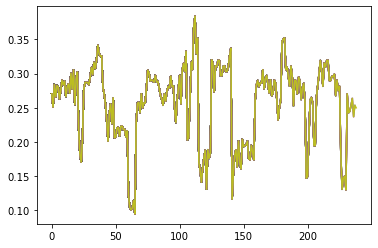

In [5]:
cap = cv2.VideoCapture(0)

# Creating a list eye_blink_signal
eye_blink_signal=[]
# Creating an object blink_ counter
counter = 0
previous_ratio = 100
sound_file = './data/alert.wav'

while True:
    ret, frame = cap.read()
    if ret is False:
        break
    #roi = frame[0: 400, 0: 400]
    #roi = cv2.resize(face_detector(frame),(0,0),None,1,1)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        x, y = face.left(), face.top()
        x1, y1 = face.right(), face.bottom()
        # Creating an object in which we will store the detected facial landmarks
        landmarks = predictor(gray, face)
        # Calculating left eye aspect ratio    
        left_eye_ratio = get_EAR([36, 37, 38, 39, 40, 41], landmarks)
        # Calculating right eye aspect ratio  
        right_eye_ratio = get_EAR([42, 43, 44, 45, 46, 47], landmarks)
        # Calculating aspect ratio for both eyes  
        blinking_ratio = (left_eye_ratio + right_eye_ratio) / 2
        #print (blinking_ratio)
        blinking_ratio_1 = blinking_ratio * 100
        blinking_ratio_2 = np.round(blinking_ratio_1)
        blinking_ratio_rounded = blinking_ratio_2 / 100
        eye_blink_signal.append(blinking_ratio)
        plt.plot(eye_blink_signal)
        # Appending blinking ratio to a list eye_blink_signal
        #print(blinking_ratio)
        #cv2.putText(frame, str(blink_counter), (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255),5)
        cv2.putText(frame, str("{:.2f}".format(blinking_ratio)), (x+10, y+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),1)
        if blinking_ratio < 0.2:
            counter = counter + 1
            if counter == 5:
                #sound_file
                winsound.PlaySound(sound_file, winsound.SND_FILENAME)
                ctypes.windll.user32.MessageBoxW(0, "Hey Hey", "Wake up", 1)
                counter = 0
                with open('data/Attendance.csv','w') as f:
                    now = datetime.now()
                    dtString = now.strftime('%H:%M:%S')
                    f.writelines(f'\n{blinking_ratio},{dtString}')
        else :
            counter = 0
        
    #plt.show()
    cv2.imshow("Roi", frame)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break    
cap.release()
cv2.destroyAllWindows()  